In [1]:
from sklearn.svm import LinearSVC
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
# read names that have provided survey eye color data
columns = ['name', 'left', 'right', 'left_desc', 'right_desc']
# pgp eye color data from survey
surveyData = pd.read_csv("PGP-eyecolor.csv", names=columns, na_values=['nan', ''])
# names of the pgp participants
surveyNames = np.asarray(surveyData['name'].values.tolist())
leftEyeColors = surveyData['left']
rightEyeColors = surveyData['right']

In [3]:
# load numpy array of names
pgpNames = np.load("names.npy")
# load numpy array of tiled data and delete the extra information
pgp = np.load("hiq-pgp.npy")
for i in range(len(pgpNames)):
    pgpNames[i] = pgpNames[i][:8]

In [4]:
def getData(name, surveyData):
    for index, row in surveyData.iterrows():
        if row['name'] == name:
            return (row['left'], row['right'])

In [5]:
# populate name dictionaries with respective eye color data
namePairIndices = []
nameLeftEyeMap = {}
nameRightEyeMap = {}
for i in range(len(pgpNames)):
    if pgpNames[i] in surveyNames:
        eyeData = getData(pgpNames[i], surveyData)
        namePairIndices.append((i, pgpNames[i]))
        nameLeftEyeMap[pgpNames[i]] = eyeData[0]
        nameRightEyeMap[pgpNames[i]] = eyeData[1]

# create lists containing the known eye color names and the unknown ones.
nameIndices = [nameIndex[0] for nameIndex in namePairIndices]
knownData = pgp[nameIndices]
unknownData = np.delete(pgp, nameIndices, axis=0)

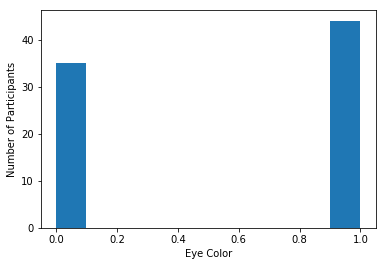

In [6]:
# convert dictionaries to lists using knownData
leftEyeNameList = []
rightEyeNameList = []

knownDataNames = [nameIndices]
for nameTuple in namePairIndices:
    leftEyeNameList.append(nameLeftEyeMap[nameTuple[1]])
    rightEyeNameList.append(nameRightEyeMap[nameTuple[1]])
    
for i in range(len(leftEyeNameList)):
    eyeColor = leftEyeNameList[i]
    if eyeColor > 12:
        leftEyeNameList[i] = 1
    else:
        leftEyeNameList[i] = 0
        
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(leftEyeNameList)
plt.ylabel("Number of Participants")
plt.xlabel("Eye Color")
plt.show()

[LibLinear]0.3125


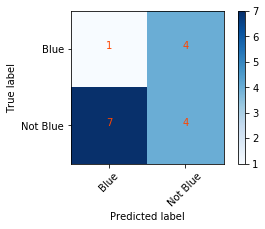

In [32]:
# from sklearn.model_selection import train_test_split
svc_test = LinearSVC(penalty='l1', class_weight='balanced', 
                         C=.04, dual=False, verbose=1, max_iter=1500)
X_train, X_test, y_train, y_test = train_test_split(knownData, leftEyeNameList, 
                                                    test_size=.2, random_state=5)
svc_test.fit(X_train, y_train)
y_pred = svc_test.predict(X_test)
print accuracy_score(y_test, y_pred)

# create confusion matrix - code taken from Sarah's blood type prediction
confusion_matrix(y_test, y_pred)
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.imshow(cnf_matrix,interpolation='nearest', cmap=plt.cm.Blues)
plt.ylabel('True label')
plt.xlabel('Predicted label')

classes = ['Blue','Not Blue']

plt.grid('off')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

for i in range(cnf_matrix.shape[0]):
    for j in  range(cnf_matrix.shape[1]):
        plt.text(j, i, cnf_matrix[i, j],
                 horizontalalignment="center",
                 color= "orangered")

plt.gcf().subplots_adjust(left=0.25, bottom = 0.35)
plt.savefig('Brown_Confusion.png',format='png',dpi=300)

In [25]:
svc_test = LinearSVC(penalty='l1', class_weight=None, 
                         C=.04, dual=False, verbose=1, max_iter=1500)
cv_scores = cross_val_score(svc_test, knownData, leftEyeNameList, cv=10, scoring='accuracy')
print
print cv_scores.mean()
print cv_scores.std()

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]
0.6875
0.176400494199


In [ ]:
# GridSearch CV to test for the C range and balance.
from sklearn.model_selection import RandomizedSearchCV

crange = np.logspace(-3, 5, 10).tolist()
weight = [None, 'balanced']

param_grid = dict(C=crange, class_weight=weight)
clf = LinearSVC(dual=False, penalty='l1', verbose=1)
rand = RandomizedSearchCV(clf, param_grid, cv=10, scoring='accuracy')
rand.fit(knownData, leftEyeNameList)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

In [ ]:
rand.grid_scores_

In [ ]:
nonzeroes = np.nonzero(svc_test.coef_[0])[0]
print svc_test.coef_[0].max()
arr = np.asarray(nonzeroes)

In [17]:
arr.dump("coefs.pkl")

In [18]:
coefs = zip(nonzeroes, svc_test.coef_[0][nonzeroes])
coefs.sort(key = lambda x: x[1], reverse=True)
print len(coefs)
for coef in coefs:
    if coef[1] > 0: print coef

53
(1940575, 0.061636187976859387)
(1207239, 0.03926145596951805)
(1394887, 0.034937445506419418)
(1866551, 0.031449450680210572)
(1089423, 0.029384773960825245)
(1912355, 0.024466391861804347)
(962743, 0.023378528275303682)
(1089916, 0.021904492994020953)
(970923, 0.0208884136403612)
(2325973, 0.016385577359045347)
(2087013, 0.015935205692007251)
(1485626, 0.012188574424717012)
(682373, 0.012164211074133784)
(1415555, 0.012099068972533539)
(1214713, 0.011306970331115695)
(1609027, 0.010532181513164275)
(401709, 0.0096356281344384676)
(1866411, 0.0091659521780010633)
(1866293, 0.0080555899939401231)
(975029, 0.0062869786745772078)
(846813, 0.0060262970948446329)
(1275283, 0.0051908332378729615)
(1846117, 0.0049878901022095429)
(584173, 0.0048025443602681874)
(1716867, 0.0012823889923459695)
(1307183, 0.00099622372199173925)
